# 17 - Bag of Visual Words

Neste roteiro iremos explorar o método Bag of Visual Words para a determinação de similaridade entre imagens. Apesar de existirem métodos prontos no OpenCV iremos implementar partes deste método nós mesmos para fixar melhor os conceitos. 

**Aviso**: Ao pesquisar sobre este modelo a maioria dos recursos será sobre classificação de imagens, mas ele também é adequado para similaridade de imagens. 

O OpenCV já possui uma implementação de *Bag of Visual Words* fácil de usar, mas ela esconde detalhes demais do funcionamento do método. Como nosso objetivo é exercitar os conceitos por trás do modelo, criaremos nossa própria versão a partir de funções auxiliares disponibilizadas pelo OpenCV e scikit-learn. No projeto você pode (deve?) usar as funções do OpenCV diretamente. 

Nosso roteiro é dividido em duas grandes etapas. A primeira etapa, feita nas partes $0-4$ é o **treinamento** do nosso modelo. É nesta etapa que selecionamos um conjunto de imagens para criar nosso vocabulário e que determinamos quantos padrões visuais colocaremos no histograma. Isto é feito com base em um algoritmo de *agrupamento*, que encontre conjuntos de padrões visuais similares. Note que não existe um gabarito que defina qual deve ser a similaridade entre as imagens nem qual o resultado de uma busca. Por isso dizemos que este tipo de modelo é **não-supervisionado**, ou seja, toda informação usada está presente nas próprias imagens. O **treinamento** pode ser um processo lento pois, idealmente, ele é feito somente uma vez. Voltaremos nesse assunto na próxima semana, então você pode prosseguir mesmo que esta explicação não esteja 100% clara. 


A segunda etapa é a **aplicação** do modelo treinado para computar similaridades entre imagens. Nesta etapa computamos a representação em histograma de padrões visuais de uma imagem de busca e fazemos a comparação com as imagens do nosso banco de dados. Esta etapa deve ser muito rápida, pois o usuário espera uma resposta rápida de sistemas de busca.

# Parte 0 - Instalação do OpenCV e banco de imagens

Os trabalhos usando o *Bag of Words* costumam usar os métodos *SIFT* ou *SURF* para extração e descrição de pontos de interesse. Estes métodos são patenteados e para usá-los é necessário  instalar o pacote *opencv-contrib-python*, disponível via *pip*. Por alguma razão a versão mais atual não contém estes métodos, então precisamos instalar uma versão específica ligeiramente mais antiga. 

**Atenção**: é necessário desinstalar seu opencv antigo antes de instalar este pacote!

    > pip install opencv-contrib-python==3.4.0.12

Hoje iremos trabalhar com as funções usadas na atividade passsada. Vamos usar também o conjunto de imagens *Caltech101*, disponíveis [aqui](http://www.vision.caltech.edu/Image_Datasets/Caltech101/#Download). 

# Parte 1 - revisão

**Exercício**: crie uma função `def computa_descritores(img)` que recebe uma imagem e devolve os descritores dela. Você deve usar o método `SURF` neste exercício e, como na atividade anterior, pode ignorar as posições de cada ponto de interesse encontrado.

In [7]:
import cv2 as cv
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pickle
from scipy.stats import chisquare

In [8]:
def compute_descriptors(img):
    surf = cv.xfeatures2d.SURF_create()
    kp, des = surf.detectAndCompute(img, None)
    return des

**Exercício**: crie uma função `def le_descritores_imagens(pastas, max_items=5)` que recebe uma lista de pastas como argumento, computa os descritores de cada imagem dentro desta pasta e retorna uma tupla contendo uma lista com o caminho todas as imagens analisadas e uma matriz contendo seus descritores. Verifique que a matriz retornada é uma matriz do `numpy` e não uma lista de listas. Para tornar nosso processamento mais rápido, processe somente as 5 primeiras imagens de cada pasta. 

**Dica**: se não souber como listar os arquivos de um diretório em Python busque pela função `os.listdir`.

In [9]:
import os
def read_descriptors(dirs, max_items=5):
    paths = []
    list_descriptors = []
    PATH = './101_ObjectCategories/'
    for _dir in dirs:
        if(_dir[0] == '.'):
            continue
        actual_path = PATHa + _dir + '/'
        images_list = (os.listdir(actual_path))
        for i in range(max_items):
            img = cv.imread(actual_path + images_list[i])
            paths.append(actual_path + images_list[i])
            descriptors = compute_descriptors(img)
            list_descriptors.append(descriptors)
    return np.vstack(list_descriptors), paths

A base de dados *Caltech101* está organizada em várias subpastas, cada uma contendo objetos de uma categoria específica. Vamos trabalhar inicialmente com as pastas `["faces", "garfield", "platypus", "nautilus", "elephant", "gerenuk"]`. Chame sua função para estas pastas e guarde os resultados obtidos. 

In [56]:
DATASET = ["Faces", "garfield", "platypus", "nautilus", "elephant", "gerenuk"]
des, paths = read_descriptors(DATASET)

# Parte 2 - Criação do vocabulário e histograma

A criação do vocabulário de padrões visuais é feita usando um algoritmo de *clustering*. Este algoritmo identifica agrupamentos de padrões visuais e retorna, para cada agrupamento, um padrão representante (chamado de centróide por ele ser a média de todos os padrões do agrupamento). Grosso modo, cada centróide representa um conjunto de padrões muito similares, logo poderíamos substituí-los pelo centróide.

A biblioteca *scikit-learn* já possui uma implementação do algoritmo *KMeans* que pode ser usada para identificar estes padrões. Veja [neste link](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) a documentação e um exemplo de uso.

Nesta parte do roteiro iremos executar a segunda parte do algoritmo: iremos criar o vocabulário e uma função que cria o histograma de padrões visuais.

**Exercício**: crie uma função `def cria_vocabulario(descritores, sz=300)` que aplica o algoritmo acima e devolve uma tupla contendo a matriz com cada centróide em uma linha e o objeto `KMeans` criado. Note que a matriz deverá ter `sz` linhas (valor padrão 300) e o mesmo número de colunas dos descritores computados na parte anterior. Você deverá chamar esta função com a matriz de descritores criada na parte anterior.

Chamaremos esta tupla nas próximas funções de vocabulário.

In [11]:
def create_vocabulary(descriptors, sz=300):
    k = KMeans(sz, random_state=0)
    k.fit(descriptors)
    return (k.cluster_centers_, k)


In [58]:
vocab = create_vocabulary(des)

**Exercício**: crie uma função `def representa_histograma(img, vocab)` que recebe uma imagem e um vocabulário e devolve um histograma que a represente. Se você estiver em dúvida como isto deve ser feito, consulte os slides desta aula.

**Dica**: o objeto `KMeans` criado na função anterior já possui uma função que calcula as distâncias até cada centróide. Consulte [sua documentação](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.transform) para entender como usá-la. 

In [59]:
def show_histogram(img, vocab):
    img = cv.imread(img)
    d = compute_descriptors(img)
    h = vocab[1].predict(d)
    ret = [1 for i in range(len(vocab[0]))]
    for i in range(len(h)):
        ret[h[i]] +=1
    plt.bar(range(len(vocab[0])), ret)
#     plt.hist(h)
    plt.show()
#     print(ret)
    return ret
    

In [106]:
def histogram(img, vocab):
    img = cv.imread(img)
    d = compute_descriptors(img)
    h = vocab[1].predict(d)
    ret = [1.0 for i in range(len(vocab[0]))]
    for i in range(len(h)):
        ret[h[i]] +=1
#     plt.hist(h)
#     plt.show()
#     print(ret)
    return ret
    

Teste sua função com alguma das imagens do *Caltech101*. 

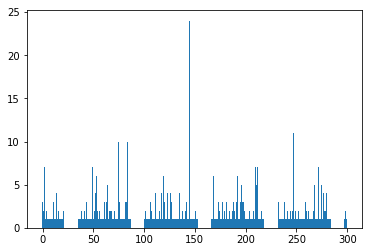

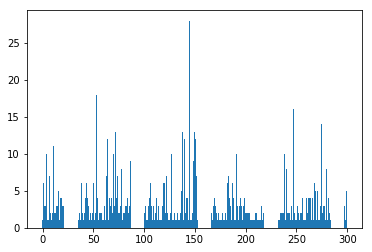

In [107]:

h1 = show_histogram("./101_ObjectCategories/airplanes/image_0002.jpg", vocab)
h2 = show_histogram("./101_ObjectCategories/airplanes/image_0005.jpg", vocab)

# Parte 3 - Similaridade entre imagens

Na última parte criamos uma função que representa uma imagem como um histograma de padrões visuais. Agora nos resta comparar duas imagens e criar um ranqueamento de quais imagens do banco de dados são mais parecidas com uma imagem de busca.

**Exercício**: Um método comum para comparação de histogramas é a utilização da distância $\chi^2$. Escreva abaixo sua fórmula e interprete-a.

sua resposta aqui

**Exercício**: o OpenCV já possui uma função de comparação de histogramas. Qual é ela? Como usá-la para computar a distância $\chi^2$.

*Sua resposta aqui*

In [147]:

# def chi_squared(hist1, hist2):
#     return chisquare(hist2, f_exp=hist1)#.statistic


# def chi_squared(hist1, hist2):
#     d = 0.5 * np.sum([((a - b) ** 2)/a for (a, b) in zip(hist1, hist2)])
#     return d

def chi_squared(h1, h2):
    h1 = np.array(h1)
    h2 = np.array(h2)
    return 0.5 * np.sum( (h1-h2)**2 / h1 )

# Parte 4 - juntando tudo

Vamos agora juntar todas as partes criadas anteriormente na versão $0.5$ de nosso buscador. Para cada pasta processada na parte 1, 

1. escolha uma imagem que não foi usada na determinação do vocabulário
2. compute a distância dela para todas as imagens do vocabulário
3. Mostre as três imagens com menor distância.

Note que os passos acima incluem representar cada imagem do vocabulário como um histograma. Tome cuidado para não fazer isto mais de uma vez. 

Faça seu código de maneira modular, de maneira que para realizar a busca você apenas chame uma função. Você pode supor que esta função recebe como entrada qualquer objeto retornado pelas funções das etapas anteriores. 

**Exercício**: mostre, visualmente, os resultados de três buscas feitas com seu trabalho e comente os resultados

In [148]:
def show_5(dist_list, original):
    plt.imshow(cv.imread(original))
    plt.show()
    for i in range(5):
        print(f"Distance: {dist_list[i][0]}")
        plt.imshow(cv.imread(dist_list[i][1]))
        plt.show()
        
def search(path, vocabulary, hist_list):
    hist = histogram(PATH, vocab)
    dist_list = [((chi_squared(hist_list[i], hist)), paths[i]) for i in range(len(hist_list))]
    sorted_list = sorted(dist_list, key=lambda x: x[0])
#     print(dist_list)
    show_5(sorted_list, PATH)

In [149]:
DATASET = ["Faces", "garfield", "platypus", "nautilus", "elephant", "gerenuk"]
# DATASET = os.listdir('./101_ObjectCategories/')
MAX_ITEMS = 10
des, paths = read_descriptors(DATASET, MAX_ITEMS)


In [150]:
# vocab = create_vocabulary(des)
# pickle_out = open("vocab.pickle","wb")
# pickle.dump(vocab, pickle_out)
# pickle_out.close()

In [151]:
# pickle_out = open("paths.pickle","wb")
# pickle.dump(paths, pickle_out)
# pickle_out.close()

In [152]:
hist_list = [histogram(paths[i], vocab) for i in range (len(DATASET) * MAX_ITEMS)]
# pickle_out = open("hist.pickle","wb")
# pickle.dump(hist_list, pickle_out)
# pickle_out.close()

In [153]:
pickle_in = open("vocab.pickle","rb")
vocab = pickle.load(pickle_in)

# pickle_in = open("hist.pickle","rb")
# hist_list = pickle.load(pickle_in)

pickle_in = open("paths.pickle","rb")
paths = pickle.load(pickle_in)

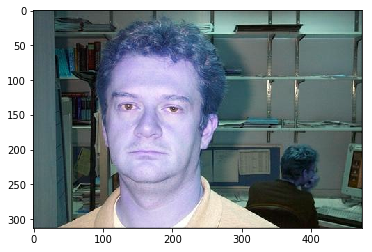

Distance: 473.35105103230103


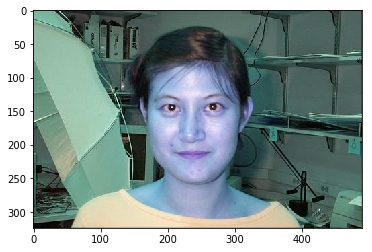

Distance: 535.3613580863581


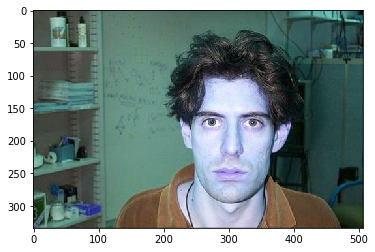

Distance: 715.6334350256614


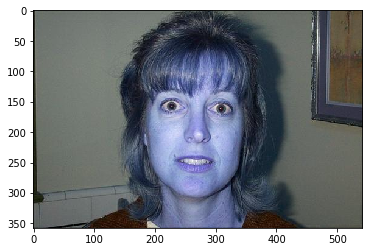

Distance: 756.8433605201988


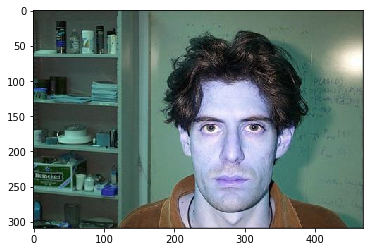

Distance: 759.9924765904384


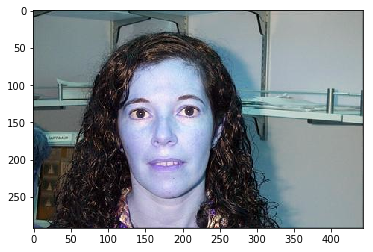

In [154]:
PATH = './101_ObjectCategories/Faces/image_0041.jpg'
search(PATH, vocab, hist_list)

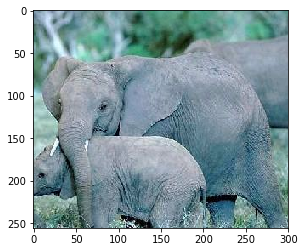

Distance: 0.0


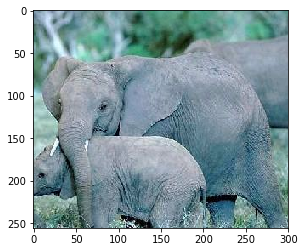

Distance: 478.6219976510418


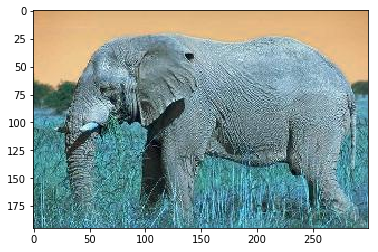

Distance: 485.9533896658897


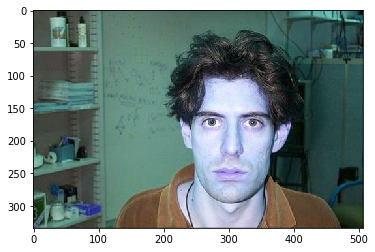

Distance: 489.31444874569866


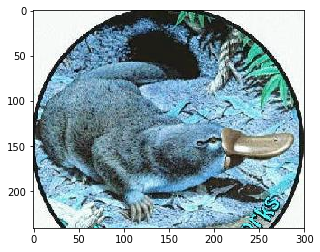

Distance: 529.3501567876568


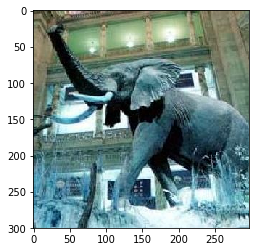

In [155]:
PATH = './101_ObjectCategories/elephant/image_0027.jpg'
search(PATH, vocab, hist_list)

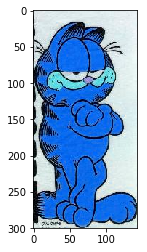

Distance: 239.787755994006


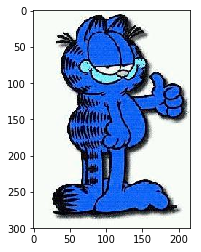

Distance: 309.93856222037334


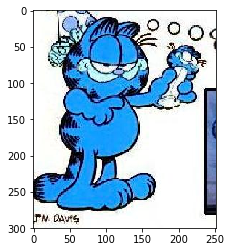

Distance: 336.14258884707965


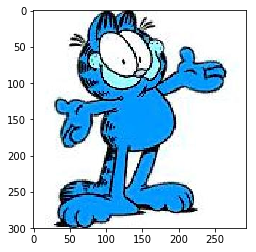

Distance: 354.5813151652763


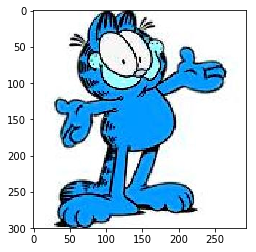

Distance: 360.90157521168254


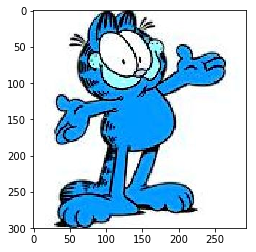

In [156]:
PATH = './101_ObjectCategories/garfield/image_0003.jpg'
search(PATH, vocab, hist_list)

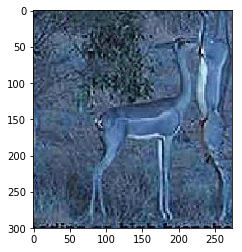

Distance: 460.20810508935506


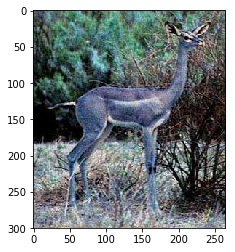

Distance: 484.4187509953815


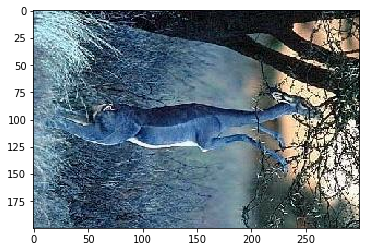

Distance: 561.2533726142278


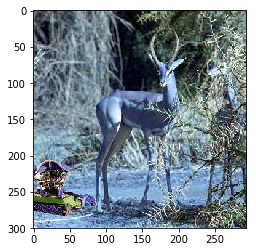

Distance: 643.5984126984126


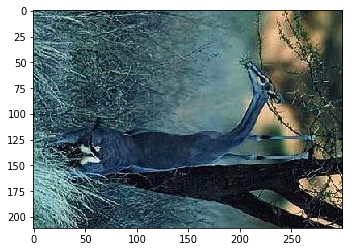

Distance: 762.1927579365079


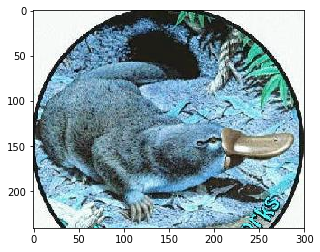

In [157]:
PATH = './101_ObjectCategories/gerenuk/image_0003.jpg'
search(PATH, vocab, hist_list)

*Comente seus resultados aqui*